In [ ]:
import torch
import torch.nn as nn
import numpy as np

from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import hf_hub_download

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) Т
Invalid input. Must be one of ('y', 'yes', '1', 'n', 'no', '0', '')
Add token as git credential? (Y/n) N
Token is valid (permission: fineGrained).
The token `Test_1` has been saved to /root/.cache/huggingface/stored_tokens
Your token has

In [ ]:
model = AutoModelForCausalLM.from_pretrained("google/gemma-2-2b", torch_dtype=torch.bfloat16, device_map="auto")
tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
path_to_params = hf_hub_download(
    repo_id="google/gemma-scope-2b-pt-res",
    filename="layer_20/width_16k/average_l0_71/params.npz",
    force_download=False,
)
# may be change the layer by sae weights

params = np.load(path_to_params)
pt_params = {k: torch.from_numpy(v).cuda() for k, v in params.items()}


params.npz:   0%|          | 0.00/302M [00:00<?, ?B/s]

In [ ]:
class JumpReLUSAE(nn.Module):
  def __init__(self, d_model, d_sae):
    # Note that we initialise these to zeros because we're loading in pre-trained weights.
    # If you want to train your own SAEs then we recommend using blah
    super().__init__()
    self.W_enc = nn.Parameter(torch.zeros(d_model, d_sae))
    self.W_dec = nn.Parameter(torch.zeros(d_sae, d_model))
    self.threshold = nn.Parameter(torch.zeros(d_sae))
    self.b_enc = nn.Parameter(torch.zeros(d_sae))
    self.b_dec = nn.Parameter(torch.zeros(d_model))

  def encode(self, input_acts):
    pre_acts = input_acts @ self.W_enc + self.b_enc
    mask = (pre_acts > self.threshold)
    acts = mask * torch.nn.functional.relu(pre_acts)
    return acts

  def decode(self, acts):
    return acts @ self.W_dec + self.b_dec

  def forward(self, acts):
    acts = self.encode(acts)
    recon = self.decode(acts)
    return recon

In [ ]:
sae = JumpReLUSAE(params['W_enc'].shape[0], params['W_enc'].shape[1]).cuda().to(torch.bfloat16)
sae.load_state_dict(pt_params)

<All keys matched successfully>

In [ ]:
def intervene_hidden_states(alpha, sae_vector_idx=12082):
    def hook(module, input, output):
        h = output[0]
        e_i = sae.W_dec[sae_vector_idx]
        h_modified = h + alpha * e_i
        return (h_modified, *output[1:])
    return hook

# hook for layer 10
layer = model.model.layers[10]
handle = layer.register_forward_hook(intervene_hidden_states(alpha=1.0))

In [ ]:
alphas = [150, 100, 80]
sae_vector_idxs = [12082, 12332, 11859]
prompt = "Who are you?"
results = {}

for alpha, sae_vector_id in zip(alphas, sae_vector_idxs):
    handle.remove()
    handle = layer.register_forward_hook(intervene_hidden_states(alpha, sae_vector_id))

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=128)
    # print(outputs.shape)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    results[alpha] = text
    print(f"Alpha={alpha}: {text}\n")
    print("========================")

Alpha=150: Who are you?

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

I’m a dog person.

Alpha=100: Who are you?

[User 0001]

Bonjour,

Je suis un jeune homme de 25 ans, je suis en train de me lancer dans le monde de l'immobilier.

Je suis en train de me lancer dans le monde de l'immobilier.

Je suis en train de me lancer dans le monde de l'immobilier.

[User 10000000000000000000000000000000000000000000000000

Alpha=80: Who are you?

I am AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I



In [ ]:
# fluency:

# {"score": 3}
# {"score": 4}
# {"score": 2}

In [ ]:
# behavioral score:

# {"score": 2}
# {"score": 3}
# {"score": 1}


In [ ]:
def intervene_hidden_states_method_2(alpha, sae_vector_idx=12082):
    def hook(module, input, output):
        h = output[0]
        e_i = sae.W_dec[sae_vector_idx]
        h_modified = h + alpha * e_i
        h_modified /= torch.norm(h_modified)
        h_modified *= torch.norm(h)
        return (h_modified, *output[1:])
    return hook

layer = model.model.layers[10]
handle = layer.register_forward_hook(intervene_hidden_states_method_2(alpha=1.0))

In [ ]:
alphas = [150, 100, 80]
sae_vector_idxs = [12082, 12332, 11859]
prompt = "Who are you?"
results = {}

for alpha, sae_vector_id in zip(alphas, sae_vector_idxs):
    handle.remove()
    handle = layer.register_forward_hook(intervene_hidden_states_method_2(alpha, sae_vector_id))

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=128)
    # print(outputs.shape)
    text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    results[alpha] = text
    print(f"Alpha={alpha}: {text}\n")
    print("========================")

Alpha=150: Who are you?

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I am a dog.

I

Alpha=100: Who are you?

Je suis un homme de 30 ans, marié et père de 2 enfants.

Je suis un homme de 30 ans, marié et père de 2 enfants.

Je suis un homme de 30 ans, marié et père de 2 enfants.

Je suis un homme de 30 ans, marié et père de 2 enfants.

Je suis un homme de 30 ans, marié et père de 2 enfants.

Je suis un homme de 30 ans, marié et père de 2 enfants.

Je suis un homme de 30 ans, marié et père

Alpha=80: Who are you?

I am AARON.

I am AARON.

I am AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM AARON.

I AM 

In [ ]:
# fluency:

# {"score": 3}

# {"score": 4}

# {"score": 2}

In [ ]:
# {"score": 1}

# {"score": 3}

# {"score": 1}

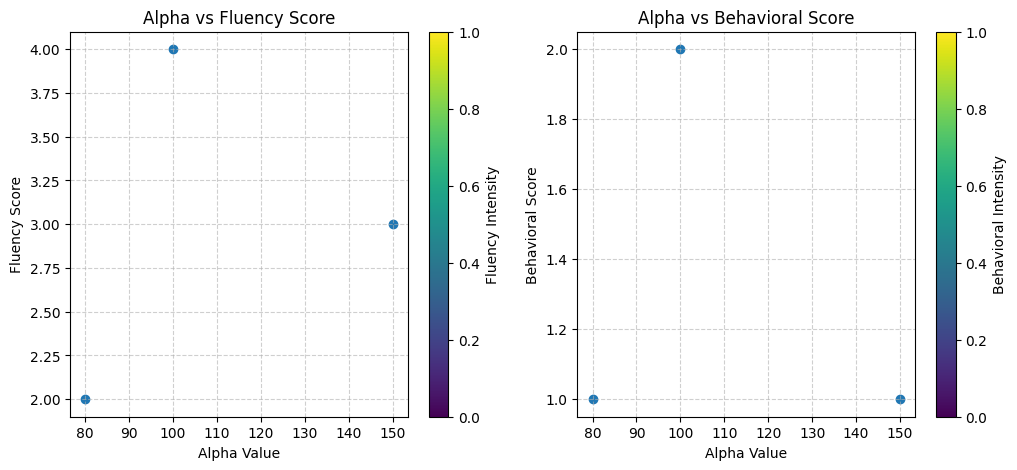

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sc1 = ax1.scatter(
  x=[150, 100, 80],
  y=[3, 4, 2]
)
ax1.set_title('Alpha vs Fluency Score')
ax1.set_xlabel('Alpha Value')
ax1.set_ylabel('Fluency Score')
ax1.grid(True, linestyle='--', alpha=0.6)
fig.colorbar(sc1, ax=ax1, label='Fluency Intensity')

sc2 = ax2.scatter(
  x=[150, 100, 80],
  y=[1, 2, 1]
)
ax2.set_title('Alpha vs Behavioral Score')
ax2.set_xlabel('Alpha Value')
ax2.set_ylabel('Behavioral Score')
ax2.grid(True, linestyle='--', alpha=0.6)
fig.colorbar(sc2, ax=ax2, label='Behavioral Intensity')

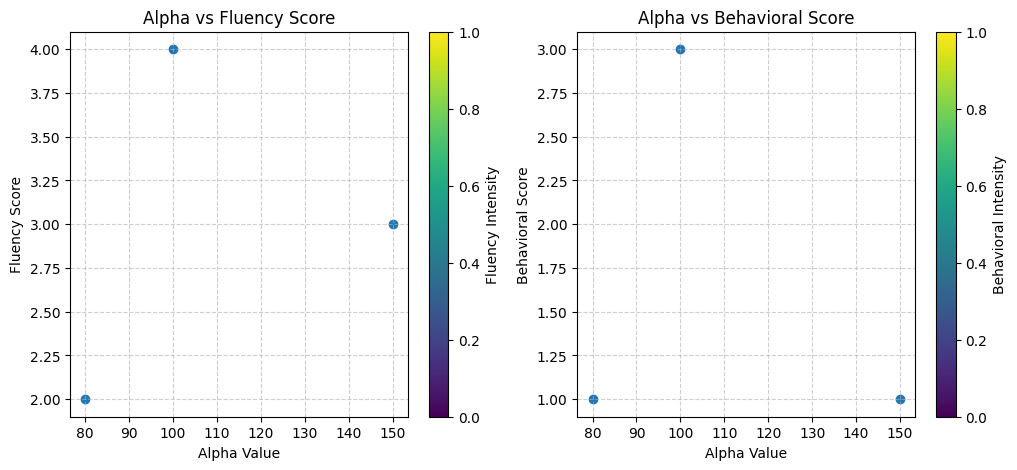

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sc1 = ax1.scatter(
  x=[150, 100, 80],
  y=[3, 4, 2]
)
ax1.set_title('Alpha vs Fluency Score')
ax1.set_xlabel('Alpha Value')
ax1.set_ylabel('Fluency Score')
ax1.grid(True, linestyle='--', alpha=0.6)
fig.colorbar(sc1, ax=ax1, label='Fluency Intensity')

sc2 = ax2.scatter(
  x=[150, 100, 80],
  y=[1, 3, 1]
)
ax2.set_title('Alpha vs Behavioral Score')
ax2.set_xlabel('Alpha Value')
ax2.set_ylabel('Behavioral Score')
ax2.grid(True, linestyle='--', alpha=0.6)
fig.colorbar(sc2, ax=ax2, label='Behavioral Intensity')